In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.datasets.mnist import FashionMNIST
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Classes

In [2]:
class FashionMNISTPairs(Dataset):
    def __init__(self, dataset: FashionMNIST, num_pairs_per_epoch=100000):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3), # Convert 1 channel to 3 channels
            transforms.Resize((224, 224)), # Resize to the size expected by ResNet18
            transforms.ToTensor()
        ])
        self.length = len(dataset)
        self.num_pairs_per_epoch = num_pairs_per_epoch
        self.pairs_indices = self.generate_pairs_indices()

    def generate_pairs_indices(self):
        pairs_indices = []
        for _ in range(self.num_pairs_per_epoch):
            i, j = random.sample(range(self.length), 2)
            pairs_indices.append((i, j))
        return pairs_indices

    def __len__(self):
        return self.num_pairs_per_epoch

    def __getitem__(self, idx):
        i, j = self.pairs_indices[idx]
        img1, label1 = self.dataset[i]
        img2, label2 = self.dataset[j]
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        return img1, img2, torch.tensor(label1), torch.tensor(label2), i, j

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super(SiameseNetwork, self).__init__()
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.fc_embedding = nn.Linear(512, 128)  # Embedding layer for Siamese Network
        self.fc_classifier = nn.Linear(128, num_classes)  # Classifier layer

    def forward(self, input1, input2):
        # Feature extraction
        feat1 = self.feature_extractor(input1)
        feat2 = self.feature_extractor(input2)

        # Flatten feature maps
        feat1 = feat1.view(feat1.size(0), -1)
        feat2 = feat2.view(feat2.size(0), -1)

        # Embedding
        emb1 = self.fc_embedding(feat1)
        emb2 = self.fc_embedding(feat2)

        # Classification
        class1 = self.fc_classifier(emb1)
        class2 = self.fc_classifier(emb2)

        return emb1, emb2, class1, class2

    def extract_features(self, input):
        with torch.no_grad():
            features = self.feature_extractor(input)
            features = features.view(features.size(0), -1)
            features = self.fc_embedding(features)
        return features

In [4]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

In [5]:
from tqdm import tqdm

class Trainer:
    def __init__(self, model, contrastive_criterion, classifier_criterion, optimizer, dataloader, device):
        self.model = model
        self.contrastive_criterion = contrastive_criterion
        self.classifier_criterion = classifier_criterion
        self.optimizer = optimizer
        self.dataloader = dataloader
        self.device = device
        self.epoch_losses = []

    def train(self, num_epochs):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            progress_bar = tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for img1, img2, label1, label2, i, j in progress_bar:
                img1, img2, label1, label2 = img1.to(self.device), img2.to(self.device), label1.to(self.device), label2.to(self.device)
                
                self.optimizer.zero_grad()
                
                emb1, emb2, class1, class2 = self.model(img1, img2)
                
                # Calculate same_label dynamically
                same_label = (label1 == label2).float()
                
                # Calculate losses
                contrastive_loss = self.contrastive_criterion(emb1, emb2, same_label)
                classifier_loss1 = self.classifier_criterion(class1, label1)
                classifier_loss2 = self.classifier_criterion(class2, label2)
                total_loss = contrastive_loss + classifier_loss1 + classifier_loss2
                
                total_loss.backward()
                self.optimizer.step()
                
                epoch_loss += total_loss.item()
                progress_bar.set_postfix(loss=total_loss.item())
            avg_epoch_loss = epoch_loss / len(self.dataloader)
            self.epoch_losses.append(avg_epoch_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss}")

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.epoch_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.show()


In [6]:
class EmbeddingVisualizer:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def extract_embeddings(self):
        self.model.to(self.device)
        self.model.eval()
        embeddings = []
        predcitions = []
        labels = []
        indices = []
        wrong_images = []

        with torch.no_grad():
            for img1, img2, label1, label2, i, j in tqdm(self.dataloader, desc="Extracting Embeddings"):
                img1, img2, label1, label2 = img1.to(self.device), img2.to(self.device), label1.to(self.device), label2.to(self.device)
                
                emb1, emb2, class1, class2 = self.model(img1, img2)
                
                _, pred1 = torch.max(class1, 1)
                _, pred2 = torch.max(class2, 1)
                
                embeddings.append(emb1.cpu().numpy())
                embeddings.append(emb2.cpu().numpy())
                
                labels.append(label1.cpu().numpy())
                labels.append(label2.cpu().numpy())
                
                predcitions.append(pred1.cpu().numpy())                
                predcitions.append(pred2.cpu().numpy())
                
                indices.extend(i.cpu().numpy())
                indices.extend(j.cpu().numpy())


                # Collect wrong images
                for k in range(label1.size(0)):
                    if label1[k].item() != class1[k].argmax().item():
                        wrong_images.append((img1[k].cpu(), label1[k].cpu(), class1[k].argmax().cpu(), i))
                    if label2[k].item() != class2[k].argmax().item():
                        wrong_images.append((img2[k].cpu(), label2[k].cpu(), class2[k].argmax().cpu(), j))

        embeddings = np.concatenate(embeddings, axis=0)
        labels = np.concatenate(labels, axis=0)
        return embeddings, labels, predcitions, indices, wrong_images

    def visualize(self, embeddings, real_labels, predicted_labels):
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(embeddings)

        plt.figure(figsize=(20, 8))

        # Plot real labels
        plt.subplot(1, 2, 1)
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=real_labels, cmap='viridis', alpha=0.5)
        plt.colorbar(scatter, ticks=range(10))
        plt.title('t-SNE visualization with Real Labels')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')

        # Plot predicted labels
        plt.subplot(1, 2, 2)
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=predicted_labels, cmap='viridis', alpha=0.5)
        plt.colorbar(scatter, ticks=range(10))
        plt.title('t-SNE visualization with Predicted Labels')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')

        plt.show()


    def plot_incorrect_images(self, incorrect_images, class_names):
        incorrect_images = [(img.squeeze(0), real, pred) for img, real, pred, idx in incorrect_images if real.item() != pred.item()]
        num_images = len(incorrect_images)
        print(num_images)
        plt.figure(figsize=(20, 20))

        for j in range(int(num_images/25)):
            plt.figure(figsize=(20, 20))
            plt.title(f'{j}')
            for i, (img, real, pred) in enumerate(incorrect_images[j*25:(j+1)*25]):
                plt.subplot(5, 5, i + 1)
                plt.imshow(img.permute(1, 2, 0).numpy())
                plt.title(f"Real: {class_names[real.item()]}, Pred: {class_names[pred.item()]}")
                plt.axis('off')

            plt.show()

In [7]:
class Tester:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def test(self):
        self.model.to(self.device)
        self.model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for img1, img2, label1, label2, i, j in tqdm(self.dataloader, desc="Testing"):
                img1, img2, label1, label2 = img1.to(self.device), img2.to(self.device), label1.to(self.device), label2.to(self.device)
                
                emb1, emb2, class1, class2 = self.model(img1, img2)
                
                _, pred1 = torch.max(class1, 1)
                _, pred2 = torch.max(class2, 1)
                
                all_labels.extend(label1.cpu().numpy())
                all_labels.extend(label2.cpu().numpy())
                all_predictions.extend(pred1.cpu().numpy())
                all_predictions.extend(pred2.cpu().numpy())

        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        print(f"Test Precision: {precision:.2f}")
        print(f"Test Recall: {recall:.2f}")
        print(f"Test F1 Score: {f1:.2f}")

        return accuracy, precision, recall, f1

In [8]:
class KNNPredictor:
    def __init__(self, knn_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors=knn_neighbors)

    def fit(self, train_embeddings, train_labels):
        self.knn.fit(train_embeddings, train_labels)

    def predict(self, embeddings):
        return self.knn.predict(embeddings)

    def evaluate(self, true_labels, predicted_labels):
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels, average='weighted')

        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")

        return accuracy, precision, recall, f1

    def get_wrong_indices(self, true_labels, predicted_labels, indices):
        wrong_indices = [index for index, (true, pred) in zip(indices, zip(true_labels, predicted_labels)) if true != pred]
        return wrong_indices

    def run(self, train_embeddings, train_labels, test_embeddings, test_labels, train_indices, test_indices):
        # Train KNN on training embeddings
        self.fit(train_embeddings, train_labels)

        # Predict train and test data using KNN
        train_predictions = self.predict(train_embeddings)
        test_predictions = self.predict(test_embeddings)

        # Evaluate the predictions
        print("Train Data Evaluation:")
        self.evaluate(train_labels, train_predictions)
        
        print("\nTest Data Evaluation:")
        self.evaluate(test_labels, test_predictions)

        # Get wrong indices for train and test data
        train_wrong_indices = self.get_wrong_indices(train_labels, train_predictions, train_indices)
        test_wrong_indices = self.get_wrong_indices(test_labels, test_predictions, test_indices)

        return train_wrong_indices, test_wrong_indices, train_predictions, test_predictions

In [9]:
class LabelNoiseAdder:
    def __init__(self, dataset, noise_level=0.1, num_classes=10):
        self.dataset = dataset
        self.noise_level = noise_level
        self.num_classes = num_classes

    def add_noise(self):
        num_noisy_samples = int(len(self.dataset) * self.noise_level)
        noisy_indices = random.sample(range(len(self.dataset)), num_noisy_samples)
        
        for idx in noisy_indices:
            original_label = self.dataset.targets[idx]
            noisy_label = random.randint(0, self.num_classes - 1)
            
            while noisy_label == original_label:
                noisy_label = random.randint(0, self.num_classes - 1)
                
            self.dataset.targets[idx] = noisy_label

# Training

In [26]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print('using device:', device)
# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

train_pairs_dataset = FashionMNISTPairs(train_dataset, num_pairs_per_epoch=50000)
test_pairs_dataset = FashionMNISTPairs(test_dataset, num_pairs_per_epoch=5000)

train_loader = DataLoader(train_pairs_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_pairs_dataset, batch_size=8, shuffle=False)

# Initialize model, loss function, and optimizer
model = SiameseNetwork()
contrastive_criterion = ContrastiveLoss()
classifier_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

using device: cuda


In [ ]:
state = torch.load('model.pth', map_location=device)
model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])
model.to(device)

In [ ]:
state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(state, 'model1.pth')

In [ ]:
# Train the model
print('starting training')
trainer = Trainer(model,contrastive_criterion, classifier_criterion, optimizer, train_loader, device)
trainer.train(num_epochs=40)

# Plot the training loss
trainer.plot_losses()

In [ ]:
# Test the model
print('starting testing')
tester = Tester(model, test_loader, device)
tester.test()

In [ ]:
# Visualize embeddings
visualizer = EmbeddingVisualizer(model, test_loader, device)
embeddings, real_labels, predicted_labels, indices, incorrect_images = visualizer.extract_embeddings()
# visualizer.visualize(embeddings, real_labels, predicted_labels)

In [23]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
visualizer.plot_incorrect_images(incorrect_images, class_names)

NameError: name 'visualizer' is not defined

In [ ]:
train_visualizer = EmbeddingVisualizer(model, train_loader, device)
train_embeddings, train_labels, train_predictions, train_indices, train_wrong_images = train_visualizer.extract_embeddings()

# Extract embeddings from test data
test_visualizer = EmbeddingVisualizer(model, test_loader, device)
test_embeddings, test_labels, test_predictions, test_indices, test_wrong_images = test_visualizer.extract_embeddings()

In [ ]:
# Initialize and run KNNPredictor
knn_predictor = KNNPredictor(knn_neighbors=5)
train_wrong_indices, test_wrong_indices, train_predictions, test_predictions = knn_predictor.run(
    train_embeddings, train_labels, test_embeddings, test_labels, train_indices, test_indices
)

# Print the indices of wrong predictions
print("Indices of wrong predictions in train data:", train_wrong_indices)
print("Indices of wrong predictions in test data:", test_wrong_indices)

# Visualize incorrect predictions from the KNN results
test_visualizer.plot_incorrect_images(test_wrong_images, class_names)

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt

def plot_wrong_predictions(test_dataset, wrong_indices, class_names):
    plt.figure(figsize=(10, 10))
    transform1 = transforms.ToTensor()
    transform2 = transforms.ToPILImage()

    for i, idx in enumerate(wrong_indices[25:50]):
        img, label = test_dataset[idx]
        
        # Convert the image to a PIL image and then to a numpy array
        img = transform2(transform1(img)).convert("L")
        img = np.array(img)

        plt.subplot(5, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Real: {class_names[label]}")
        plt.axis('off')

    plt.show()

# Plot wrong predictions from test dataset
plot_wrong_predictions(test_dataset, test_wrong_indices, class_names)

# Noise Detection

In [10]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from collections import defaultdict
import random
from torchvision import transforms
from torchvision.datasets import FashionMNIST

In [166]:
class NoiseDetector:
    def __init__(self, model_class, dataset, device, batch_size=256, num_folds=5, model_save_path="model_fold_{}.pth"):
        self.model_class = model_class
        self.dataset = dataset
        self.device = device
        self.batch_size = batch_size
        self.num_folds = num_folds
        self.model_save_path = model_save_path
        
        self.models = [self.model_class().to(self.device) for _ in range(num_folds)]
        self.kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        self.trainers = []
        self.testers = []

    def train_models(self, num_epochs=10):
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(self.dataset)):
            print(f'Training fold {fold + 1}/{self.num_folds}...')
            train_subset = Subset(self.dataset, train_idx)
            val_subset = Subset(self.dataset, val_idx)
            train_loader = DataLoader(FashionMNISTPairs(train_subset, 25000), batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(FashionMNISTPairs(val_subset, 2500), batch_size=8, shuffle=False)

            model = self.model_class().to(self.device)
            optimizer = optim.Adam(model.parameters())
            criterion = nn.CrossEntropyLoss()
            contrastive_criterion = ContrastiveLoss()

            trainer = Trainer(model, contrastive_criterion, criterion, optimizer, train_loader, self.device)

            trainer.train(num_epochs)  # Number of epochs can be adjusted

            tester = Tester(model, val_loader, self.device)
            tester.test()
            # Save the trained model
            model_save_path = self.model_save_path.format(fold + 1)
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')

            # Deallocate GPU resources by moving the model to CPU
            model.to('cpu')
            torch.cuda.empty_cache()

            print(f'Finished training fold {fold + 1}')

    def get_predictions(self, dataloader):
        all_predictions = defaultdict(list)

        for fold in range(self.num_folds):
            # Reload the model
            model = self.model_class().to(self.device)
            model_save_path = self.model_save_path.format(fold + 1)
            model.load_state_dict(torch.load(model_save_path, map_location=self.device))
            model.eval()

            with torch.no_grad():
                seen_indices = set()
                for img1, img2, label1, label2, i, j in tqdm(dataloader, desc=f"Extracting Predictions for fold {fold + 1}"):
                    img1, img2 = img1.to(self.device), img2.to(self.device)
                    emb1, emb2, class1, class2 = model(img1, img2)
                    outputs1 = nn.functional.softmax(class1, dim=1)
                    outputs2 = nn.functional.softmax(class2, dim=1)
                    
                    for idx, idx_i in enumerate(i):
                        if idx_i.item() not in seen_indices:
                            all_predictions[idx_i.item()].append(outputs1[idx].cpu().numpy())
                            seen_indices.add(idx_i.item())
                    
                    for idx, idx_j in enumerate(j):
                        if idx_j.item() not in seen_indices:
                            all_predictions[idx_j.item()].append(outputs2[idx].cpu().numpy())
                            seen_indices.add(idx_j.item())

        return all_predictions

    def calculate_variance(self, predictions):
        variances = {}
        for idx, probs in predictions.items():
            probs_array = np.array(probs)
            argmax_preds = np.argmax(probs_array, axis=1)
            variances[idx] = np.var(argmax_preds) / len(argmax_preds)
        return variances

    def calculate_entropy(self, predictions):
        entropies = {}
        for idx, probs in predictions.items():
            probs_array = np.array(probs)
            entropy = -np.sum(probs_array * np.log(probs_array + 1e-8), axis=1)
            avg_entropy = entropy.mean()
            entropies[idx] = avg_entropy
        return entropies
    
    def calculate_entropy_2(self, predictions):
        entropies = {}
        for idx, probs in predictions.items():
            probs_array = np.array(probs)
            entropy = -np.sum(probs_array * np.log(probs_array + 1e-8), axis=0)
            r = 1
            for i in range(len(entropy)):
                r *= entropy[i]
            entropies[idx] = r
        return entropies
    
    def calculate_entropy_3(self, predictions, k):
        entropies = {}
        for idx, probs in predictions.items():
            probs_array = np.array(probs)
            entropy = -np.sum(probs_array * np.log(probs_array + 1e-8), axis=0)
            r = 1
            entropy = np.sort(entropy)[::-1]
            for i in range(k):
                r *= entropy[i]
            entropies[idx] = r
        return entropies
    
    def calculate_entropy_4(self, predictions, k):
        entropies = {}
        for idx, probs in predictions.items():
            probs_array = np.array(probs)
            entropy = -np.sum(probs_array * np.log(probs_array + 1e-8), axis=0)
            r = 1
            entropy = np.sort(entropy)
            for i in range(k):
                r *= entropy[i]
            entropies[idx] = r
        return entropies

In [15]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
test_dataset = FashionMNIST(root='data', train=False, download=False)

train_noise_adder = LabelNoiseAdder(train_dataset, noise_level=0.1, num_classes=10)
train_noise_adder.add_noise()


In [18]:
test_noise_adder = LabelNoiseAdder(test_dataset, noise_level=0.1, num_classes=10)
test_noise_adder.add_noise()

In [25]:
len(test_dataset)

10000

In [167]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_detector = NoiseDetector(SiameseNetwork, train_dataset, device, model_save_path="model_fold_{}.pth")

# Train models
# noise_detector.train_models(num_epochs=15)



In [ ]:

# Get predictions for the test data
test_dataset_pair = FashionMNISTPairs(test_dataset, num_pairs_per_epoch=15000)
test_loader = DataLoader(test_dataset_pair, batch_size=1024, shuffle=False)
test_predictions = noise_detector.get_predictions(test_loader)


In [178]:

# Calculate variance of the argmax of probabilities for each i and j
variances = noise_detector.calculate_variance(test_predictions)
entropies = noise_detector.calculate_entropy_3(test_predictions, 2)
entropies2 = noise_detector.calculate_entropy_4(test_predictions, 2)
entropies3 = noise_detector.calculate_entropy_2(test_predictions)

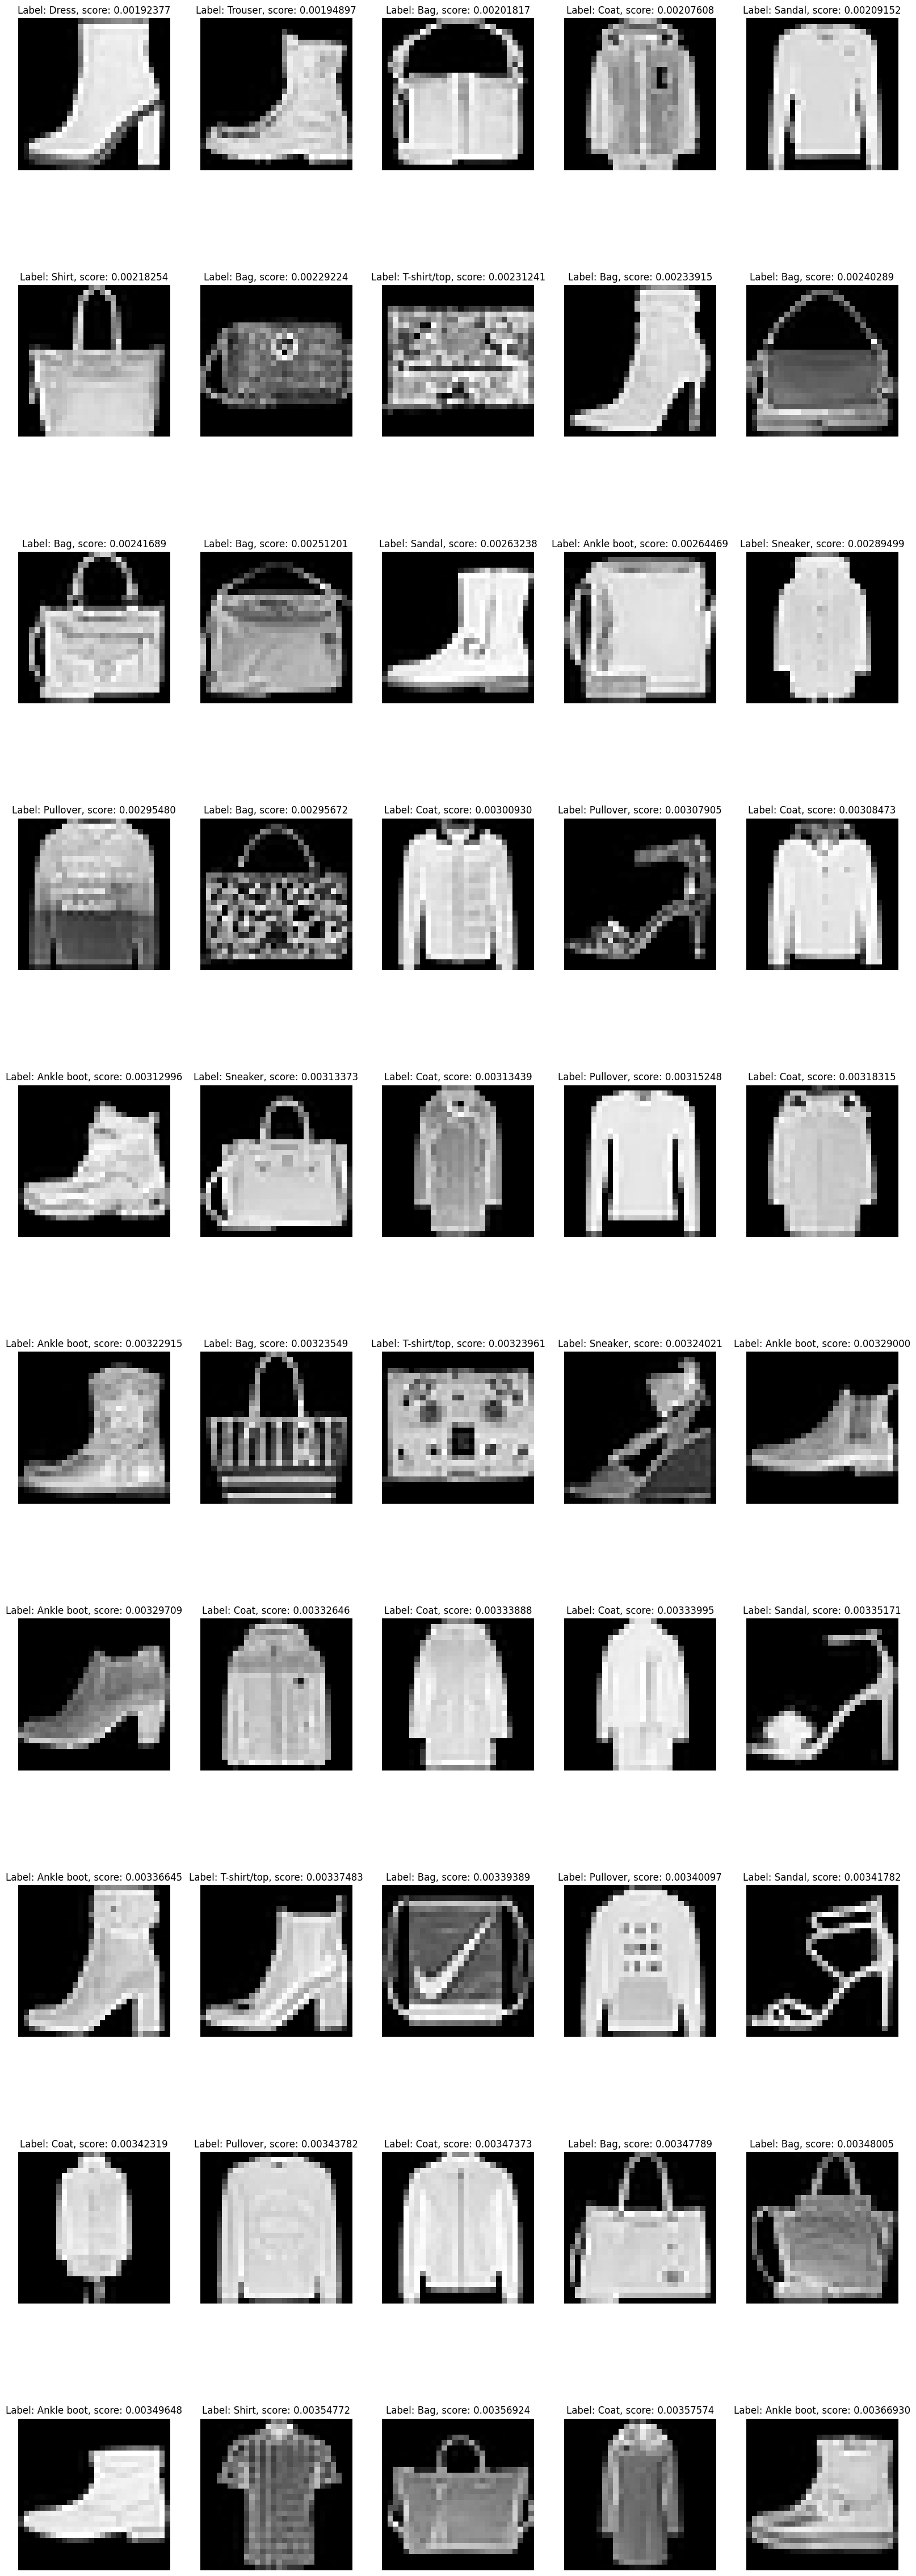

In [180]:
# sorted_indices = sorted(variances, key=variances.get, reverse=True)[:50]
measure = entropies2
sorted_indices = sorted(measure, key=measure.get, reverse=False)[:50]

transform1 = transforms.ToTensor()
transform2 = transforms.ToPILImage()

plt.figure(figsize=(20, 60))
for i, idx in enumerate(sorted_indices):
    img, label = test_dataset[idx]
    img = transform2(transform1(img)).convert("L")
    img = np.array(img)
    plt.subplot(10, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {class_names[label]}, score: {measure[idx]:.8f}")
    plt.axis('off')
plt.show()